# This notebook is used to create a logistic regression classifier as well as Random Forest classifiers for 2D and 3D features as well as evaluate the models and store them, along with their results on the test set.

In [2]:
# Import
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tifffile import imread
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay, roc_auc_score
import sklearn.metrics as metrics
import os
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from itertools import product
from joblib import Parallel, delayed


In [3]:
# Load files

# Load coord dict
big_dict = {}
for file in os.listdir('H:/agreic/coord/'):
    if file.endswith('.pkl'):
        with open('H:/agreic/coord/' + file, 'rb') as f:
            big_dict[file] = pickle.load(f)
big_dict = dict(sorted(big_dict.items()))

# Load processed feature files
features_df_dict = {}
for file in os.listdir('H:/agreic/2D_3D_features/'):
    if file.endswith('.csv'):
        with open('H:/agreic/2D_3D_features/' + file) as f:
            features_df_dict[file] = pd.read_csv(f)

# Load images
images_tif_dict = {}
for file in os.listdir('H:/agreic/image/'):
    if file.endswith('.tif'):
        images_tif_dict[file] = imread('H:/agreic/image/' + file)
# sort
features_df_dict = dict(sorted(features_df_dict.items()))
images_tif_dict = dict(sorted(images_tif_dict.items()))



In [4]:
# Here we assign test,train,validation sets
# Hoxb5 (first experiment) will be training data set.
# 0_55 is second experiment (test set, second largest, curated by DS).
# Other two are from third exp (the ones I curated) are for validation set (BOTH!).

print(features_df_dict.keys())
validation_images = {}
# Assigning the training set
train_2D = features_df_dict['features_2D_Hoxb5.csv']
train_3D = features_df_dict['features_3D_Hoxb5.csv']
train_images = images_tif_dict['Hoxb5.tif']
# Assigning the test set
test_2D = features_df_dict['features_2D_0_55.csv']
test_3D = features_df_dict['features_3D_0_55.csv']
test_images = images_tif_dict['0_55.tif']
test_pkl = big_dict['0_55.pkl']
# Assigning the validation set
validation_2D = pd.concat([features_df_dict['features_2D_1000.csv'], features_df_dict['features_2D_950.csv']])
validation_3D = pd.concat([features_df_dict['features_3D_1000.csv'], features_df_dict['features_3D_950.csv']])
validation_images[1] = images_tif_dict['1000.tif']
validation_images[2] = images_tif_dict['950.tif']

dict_keys(['features_2D_0_55.csv', 'features_2D_1000.csv', 'features_2D_950.csv', 'features_2D_Hoxb5.csv', 'features_3D_0_55.csv', 'features_3D_1000.csv', 'features_3D_950.csv', 'features_3D_Hoxb5.csv'])


In [5]:
# filtering

# Remove any columns containing NaN values, but print them first
print(train_2D.columns[train_2D.isna().any()].tolist())
print(test_2D.columns[test_2D.isna().any()].tolist())
print(validation_2D.columns[validation_2D.isna().any()].tolist())
print(train_3D.columns[train_3D.isna().any()].tolist())
print(test_3D.columns[test_3D.isna().any()].tolist())
print(validation_3D.columns[validation_3D.isna().any()].tolist())

train_2D = train_2D.dropna(axis=1)
train_3D = train_3D.dropna(axis=1)
test_2D = test_2D.dropna(axis=1)
test_3D = test_3D.dropna(axis=1)
validation_2D = validation_2D.dropna(axis=1)
validation_3D = validation_3D.dropna(axis=1)

# Check if all columns are the same, by comparing the columns of the first dataframe with the rest
print(train_2D.shape), print(test_2D.shape), print(validation_2D.shape)
print(train_3D.shape), print(test_3D.shape), print(validation_3D.shape)

# check what columns are different between the dataframes
diff_cols_2D = []
for i in [test_2D, validation_2D]:
    if train_2D.columns.difference(i.columns).any():
        diff_cols_2D.append(train_2D.columns.difference(i.columns))

diff_cols_2D = list(set([item for sublist in diff_cols_2D for item in sublist]))
print(f'2D:', diff_cols_2D)

diff_cols_3D = []
for i in [test_3D, validation_3D]:
    if train_3D.columns.difference(i.columns).any():
        diff_cols_3D.append(train_3D.columns.difference(i.columns))
diff_cols_3D = list(set([item for sublist in diff_cols_3D for item in sublist]))
print(f'3D:', diff_cols_3D)

# Check if all columns are the same, by comparing the columns of the first dataframe with the rest

# # Remove the different columns from the dataframes
for cols in diff_cols_2D:
    if cols in train_2D.columns:
        train_2D.drop(columns=[cols], inplace=True)
    if cols in test_2D.columns:
        test_2D.drop(columns=[cols], inplace=True)
    if cols in validation_2D.columns:
        validation_2D.drop(columns=[cols], inplace=True)

for cols3d in diff_cols_3D:
    if cols3d in train_3D.columns:
        train_3D.drop(columns=[cols3d], inplace=True)
    if cols3d in test_3D.columns:
        test_3D.drop(columns=[cols3d], inplace=True)
    if cols3d in validation_3D.columns:
        validation_3D.drop(columns=[cols3d], inplace=True)
# Print final shapes
print(train_2D.shape), print(test_2D.shape), print(validation_2D.shape)
print(train_3D.shape), print(test_3D.shape), print(validation_3D.shape)

['moments_normalized-0-0', 'moments_normalized-0-1', 'moments_normalized-1-0', 'moments_weighted_normalized-0-0', 'moments_weighted_normalized-0-1', 'moments_weighted_normalized-1-0']
['moments_normalized-0-0', 'moments_normalized-0-1', 'moments_normalized-1-0', 'moments_weighted_normalized-0-0', 'moments_weighted_normalized-0-1', 'moments_weighted_normalized-1-0']
['moments_normalized-0-0', 'moments_normalized-0-1', 'moments_normalized-1-0', 'moments_weighted_normalized-0-0', 'moments_weighted_normalized-0-1', 'moments_weighted_normalized-1-0']
['moments_normalized-0-0-0', 'moments_normalized-0-0-1', 'moments_normalized-0-1-0', 'moments_normalized-1-0-0', 'moments_weighted_normalized-0-0-0', 'moments_weighted_normalized-0-0-1', 'moments_weighted_normalized-0-1-0', 'moments_weighted_normalized-1-0-0']
['moments_normalized-0-0-0', 'moments_normalized-0-0-1', 'moments_normalized-0-1-0', 'moments_normalized-1-0-0', 'moments_weighted_normalized-0-0-0', 'moments_weighted_normalized-0-0-1', 

C:\Users\agreicius\AppData\Local\Temp\ipykernel_29528\2771527166.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_3D.drop(columns=[cols3d], inplace=True)


(None, None, None)

In [6]:
# We will use the training set to train the model
# We will use the validation set to validate the model
# We will use the test set to test the model

scaler = StandardScaler()

def trim(x):
    x = x.loc[:, ~x.columns.str.contains('Identifier')] # These are not useful
    return x

train_2D = trim(train_2D)
train_3D = trim(train_3D)
test_2D = trim(test_2D)
test_3D = trim(test_3D)
validation_2D = trim(validation_2D)
validation_3D = trim(validation_3D)

# 2D
train_X2 = train_2D.drop(columns=['label'])
train_X2 = scaler.fit_transform(train_X2)
train_y2 = train_2D['label']
test_X2 = test_2D.drop(columns=['label'])
test_X2 = scaler.transform(test_X2)
test_y2 = test_2D['label']
validation_X2 = validation_2D.drop(columns=['label'])
validation_X2 = scaler.transform(validation_X2)
validation_y2 = validation_2D['label']

# 3D
train_X3 = train_3D.drop(columns=['label'])
train_X3 = scaler.fit_transform(train_X3)
train_y3 = train_3D['label']
test_X3 = test_3D.drop(columns=['label'])
test_X3 = scaler.transform(test_X3)
test_y3 = test_3D['label']
validation_X3 = validation_3D.drop(columns=['label'])
validation_X3 = scaler.transform(validation_X3)
validation_y3 = validation_3D['label']

First, we test logreg:

In [7]:
# Create models
model2 = LogisticRegression(max_iter=1000, class_weight='balanced')
model3 = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train models
model2.fit(train_X2, train_y2)
model3.fit(train_X3, train_y3)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [8]:
# Gather statistics of how each model performs
# 2D
train_pred2 = model2.predict(train_X2)
test_pred2 = model2.predict(test_X2)
val_pred2 = model2.predict(validation_X2)

# 3D
train_pred3 = model3.predict(train_X3)
test_pred3 = model3.predict(test_X3)
val_pred3 = model3.predict(validation_X3)

2D

Train accuracy: 1.0
Test accuracy: 0.9919484702093397
Validation accuracy: 0.9827586206896551
Confusion matrix [Test]:
[[1187    1]
 [   9   45]]
Confusion matrix [Validation]:
[[1033    1]
 [  18   50]]
ROC AUC [Train]: 1.0
ROC AUC [Test]: 0.981341189674523
ROC AUC [Validation]: 0.9670184321310729
Precision [Test]: 0.9782608695652174
Recall [Test]: 0.8333333333333334
Precision [Validation]: 0.9803921568627451
Recall [Validation]: 0.7352941176470589
##################################################
ROC [Test]
ROC [Validation]
Precision Recall [Test]
[0.04347826 0.97826087 1.        ] [1.         0.83333333 0.        ]


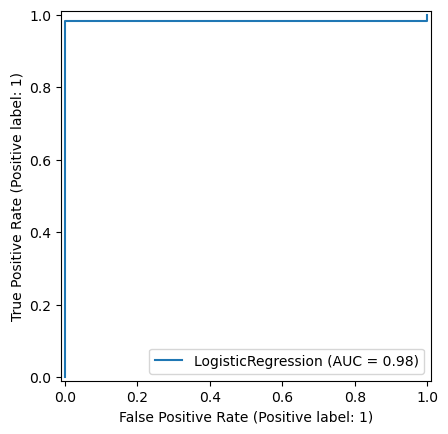

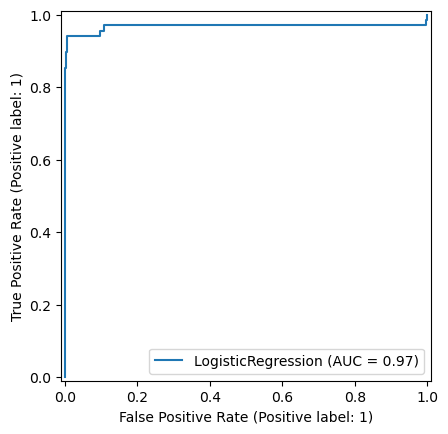

In [9]:

# Print statistics
print('2D\n')
print('Train accuracy:', accuracy_score(train_y2, train_pred2))
print('Test accuracy:', accuracy_score(test_y2, test_pred2))
print('Validation accuracy:', accuracy_score(validation_y2, val_pred2))
print('Confusion matrix [Test]:')
print(confusion_matrix(test_y2, test_pred2))
print('Confusion matrix [Validation]:')
print(confusion_matrix(validation_y2, val_pred2))

print('ROC AUC [Train]:', roc_auc_score(train_y2, model2.predict_proba(train_X2)[:, 1]))
print('ROC AUC [Test]:', roc_auc_score(test_y2, model2.predict_proba(test_X2)[:, 1]))
print('ROC AUC [Validation]:', roc_auc_score(validation_y2, model2.predict_proba(validation_X2)[:, 1]))

print(f'Precision [Test]: {precision_score(test_y2, test_pred2)}')
print(f'Recall [Test]: {recall_score(test_y2, test_pred2)}')
print(f'Precision [Validation]: {precision_score(validation_y2, val_pred2)}')
print(f'Recall [Validation]: {recall_score(validation_y2, val_pred2)}')


print('#' * 50)

print('ROC [Test]')
RocCurveDisplay.from_estimator(model2, test_X2, test_y2)

print('ROC [Validation]')
RocCurveDisplay.from_estimator(model2, validation_X2, validation_y2)

precision, recall, thresholds = metrics.precision_recall_curve(test_y2, test_pred2)
print('Precision Recall [Test]')
print(precision, recall)



3D
Train accuracy: 1.0
Test accuracy: 0.9967793880837359
Validation accuracy: 0.984573502722323
Confusion matrix [Test]:
[[1188    0]
 [   4   50]]
Confusion matrix [Validation]:
[[1033    1]
 [  16   52]]
ROC AUC [Train]: 1.0
ROC AUC [Test]: 0.9998908841501434
ROC AUC [Validation]: 0.9950364091477983
Precision [Test] = 1.0
Recall [Test] = 0.9259259259259259
Precision [Validation] = 0.9811320754716981
Recall [Validation] = 0.7647058823529411
##################################################
ROC [Test]
ROC [Validation]


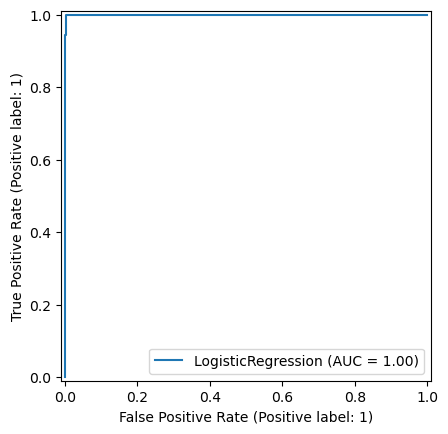

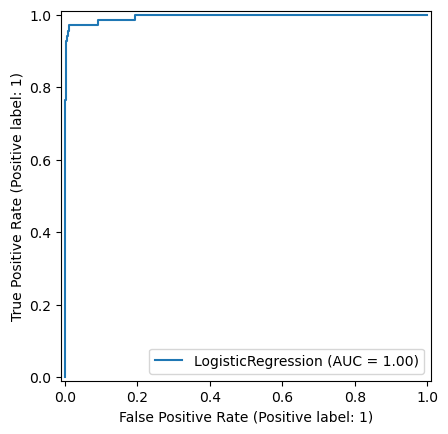

In [10]:
print('3D')

print('Train accuracy:', accuracy_score(train_y3, train_pred3))
print('Test accuracy:', accuracy_score(test_y3, test_pred3))
print('Validation accuracy:', accuracy_score(validation_y3, val_pred3))
print('Confusion matrix [Test]:')
print(confusion_matrix(test_y3, test_pred3))
print('Confusion matrix [Validation]:')
print(confusion_matrix(validation_y3, val_pred3))

print('ROC AUC [Train]:', roc_auc_score(train_y3, model3.predict_proba(train_X3)[:, 1]))
print('ROC AUC [Test]:', roc_auc_score(test_y3, model3.predict_proba(test_X3)[:, 1]))
print('ROC AUC [Validation]:', roc_auc_score(validation_y3, model3.predict_proba(validation_X3)[:, 1]))

print(f'Precision [Test] = {precision_score(test_y3, test_pred3)}')
print(f'Recall [Test] = {recall_score(test_y3, test_pred3)}')

print(f'Precision [Validation] = {precision_score(validation_y3, val_pred3)}')
print(f'Recall [Validation] = {recall_score(validation_y3, val_pred3)}')

print('#' * 50)

print('ROC [Test]')
RocCurveDisplay.from_estimator(model3, test_X3, test_y3)

print('ROC [Validation]')
RocCurveDisplay.from_estimator(model3, validation_X3, validation_y3)

## We test RF below, with hyperparam search, repeating for 5 iterations.

In [11]:
param_grid = {
    'n_estimators': [10, 20, 50, 100],  # Number of trees
    'criterion': ['gini', 'entropy', 'log_loss'],  # Split criterion
    'max_depth': [None, 10, 20, 30],  # Max depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4, 5],  # Minimum samples at each leaf node
    'bootstrap': [True, False],  # Bootstrap samples when building trees
    'max_features': ['sqrt', 'log2', None],  # Number of features for the best split
}

# Function to train a single model
def train_single_model(index, param_set, train_X2, train_y2, save_dir):
    n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, bootstrap, max_features, class_weight = param_set

    # Initialize RandomForestClassifier with the current set of hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        max_features=max_features,
        class_weight=class_weight
    )

    # Train the model
    rf.fit(train_X2, train_y2)

    # Save model using a unique name based on the combination
    model_name = f'rf_model_{index}_{n_estimators}_{criterion}_{max_depth}_{min_samples_split}_{min_samples_leaf}_{bootstrap}_{max_features}_{class_weight}.pkl'
    with open(os.path.join(save_dir, model_name), 'wb') as f:
        pickle.dump(rf, f)

def perform_training(param_grid, train_X2, train_y2, save_dir):
    # Generate all combinations of hyperparameters
    param_combinations = list(product(
        param_grid['n_estimators'],
        param_grid['criterion'],
        param_grid['max_depth'],
        param_grid['min_samples_split'],
        param_grid['min_samples_leaf'],
        param_grid['bootstrap'],
        param_grid['max_features'],
        ['balanced', None]  # Include class_weight manually
    ))

    # Parallelize training using joblib
    Parallel(n_jobs=-1)(
        delayed(train_single_model)(index, param_set, train_X2, train_y2, save_dir)
        for index in range(5)
        for param_set in param_combinations
    )

# Function to evaluate a single model
def evaluate_single_model(model_name, model, test_X2, test_y2):
    # Predict using the test set
    test_pred = model.predict(test_X2)

    # Calculate metrics
    accuracy = accuracy_score(test_y2, test_pred)
    precision = precision_score(test_y2, test_pred)
    recall = recall_score(test_y2, test_pred)
    roc_auc = roc_auc_score(test_y2, model.predict_proba(test_X2)[:, 1])

    # Return the results
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'hyperparameters': model.get_params()
    }

def evaluate_models(model_dir, test_X2, test_y2, metric='roc_auc'):
    # Load all models
    models = {}
    for file in os.listdir(model_dir):
        if file.endswith('.pkl'):
            with open(os.path.join(model_dir, file), 'rb') as f:
                models[file] = pickle.load(f)

    # Parallelize model evaluations using joblib
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_single_model)(model_name, model, test_X2, test_y2)
        for model_name, model in models.items()
    )

    # Convert the results to a dictionary and sort by the chosen metric
    results_dict = {result['model_name']: result for result in results}
    results_dict = dict(sorted(results_dict.items(), key=lambda x: x[1][metric], reverse=True))

    # Save the results as a DataFrame
    results_df = pd.DataFrame(results_dict).T
    results_df.to_csv(os.path.join(model_dir, 'results.csv'))

    return results_df


In [14]:
# root_dir = 'H:/agreic/Project/Baseline_models/'
# # Using 2D data:
# save_dir = root_dir + '2D/'
# validation_2d = evaluate_models(save_dir+'val', validation_X2, validation_y2)
# perform_training(param_grid, train_X2, train_y2, save_dir)
# results_df = evaluate_models(save_dir, test_X2, test_y2)

# # Using 3D data:
# save_dir = root_dir + '3D/'
# perform_training(param_grid, train_X3, train_y3, save_dir)
# validation_3d = evaluate_models(save_dir+'val', validation_X3, validation_y3)
# results_df = evaluate_models(save_dir, test_X3, test_y3)

In [ ]:
# # Save results in a better way:
# results_df_2D.to_pickle(root_dir + '2D/results_2D.pkl')
# results_df_3D.to_pickle(root_dir + '3D/results_3D.pkl')

# # Save validation results
# validation_2d.to_pickle(root_dir + '2D/validation_2D.pkl')
# validation_3d.to_pickle(root_dir + '3D/validation_3D.pkl')

## BELOW, DELETE LATER:

In [15]:
# # Load results_df from 2D:
# results_df_2D = pd.read_csv(root_dir + '2D/results.csv')
# results_df_3D = pd.read_csv(root_dir + '3D/results.csv')

# # Print head of the results
# print(results_df_2D.head())
# print(results_df_3D.head())

                                          Unnamed: 0  \
0       rf_model_0_50_gini_20_2_4_True_log2_None.pkl   
1  rf_model_0_10_log_loss_30_10_5_True_log2_None.pkl   
2  rf_model_0_20_log_loss_20_10_5_True_log2_None.pkl   
3  rf_model_0_20_log_loss_20_5_4_True_sqrt_balanc...   
4    rf_model_1_50_entropy_10_2_5_True_sqrt_None.pkl   

                                          model_name  accuracy  precision  \
0       rf_model_0_50_gini_20_2_4_True_log2_None.pkl  0.991948        1.0   
1  rf_model_0_10_log_loss_30_10_5_True_log2_None.pkl  0.991143        1.0   
2  rf_model_0_20_log_loss_20_10_5_True_log2_None.pkl  0.993559        1.0   
3  rf_model_0_20_log_loss_20_5_4_True_sqrt_balanc...  0.995169        1.0   
4    rf_model_1_50_entropy_10_2_5_True_sqrt_None.pkl  0.994364        1.0   

     recall   roc_auc                                    hyperparameters  
0  0.814815  0.999906  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
1  0.796296  0.999891  {'bootstrap': True, 'ccp_al

In [16]:
root_dir = 'H:/agreic/Project/Baseline_models/'
    # Careful - this will overwrite files, if not saved properly
# Using 2D data:
save_dir = root_dir + '2D/'
validation_2d = evaluate_models(save_dir, validation_X2, validation_y2)

# Save validation results
validation_2d.to_pickle(root_dir + '2D/validation_2D.pkl')

# Using 3D data:
save_dir = root_dir + '3D/'
validation_3d = evaluate_models(save_dir, validation_X3, validation_y3)

# Save validation results
validation_3d.to_pickle(root_dir + '3D/validation_3D.pkl')
